In [2]:
from weakref import finalize

import pandas as pd
pd.set_option('display.max_columns',None)
# CSV raw datasets
SCATS_DATA_OCTOBER_2006_CSV_PATH = 'datasets/Scats Data October 2006.csv'
SCATS_SITE_LISTING_SPREADSHEET_VICROADS_CSV_PATH = 'datasets/SCATSSiteListingSpreadsheet_VicRoads.csv'
TRAFFIC_COUNT_LOCATIONS_WITH_LONG_LAT_CSV_PATH = 'datasets/Traffic_Count_Locations_with_LONG_LAT.csv'

# reading the csv files
df_scats_data_october = pd.read_csv(SCATS_DATA_OCTOBER_2006_CSV_PATH,header = 1)
df_scats_site_listing = pd.read_csv(SCATS_SITE_LISTING_SPREADSHEET_VICROADS_CSV_PATH,skiprows=8, header=1)
df_traffic_long_lat = pd.read_csv(TRAFFIC_COUNT_LOCATIONS_WITH_LONG_LAT_CSV_PATH)

In [3]:
# removing the -1 values (-1 values are irrelevant)
df_scats_data_october = df_scats_data_october[df_scats_data_october['HF VicRoads Internal'] != -1]

# **CD_MELWAYS Values**

#### SCATSSiteListingSpreadsheet ("Map reference" column)
- Based on my analysis and assumptions, the SCATSSiteListingSpreadsheet contains all of Boroondarah SCATS sites (4500+ SCATS sites). This includes the Intersections (INT), Pedestrian Crossing (POS), etc, as mentioned in the Data information workbook.

#### SCATS Data October 2006 ("CD_MELWAY" column)
- This spreadsheet contains all the traffic flow recorded over the span of 31 days in 15 minutes intervals within 40 different SCATS sites. 

#### Usage
- In the SCATS Data October 2006, there are 40 unique "CD_MELWAY" values, which aligns with "Map reference" values in the SCATSSiteListingSpreadsheet.
- Having this information we can eliminate all the other values in SCATSSiteListingSpreadsheet that's not in SCATS Data October 2006 data set. The 'CD_MELWAYS' allow us to pinpoint the connections between each nodes. In simple terms, we pick only the useful rows in SCATSSiteListingSpreadsheet judging from the values we have in SCATS Data October 2006. **Only a handful of SCATSSiteListingSpreadsheet values are useful**  
- The SCATS number in the SCATS Data October 2006 represents a range of SCATS sites, corresponding to the SCATS sites in SCATSSiteListingSpreadsheet.

In [4]:
df_scats_data_october = df_scats_data_october.rename(columns={"CD_MELWAY": "CD_MELWAYS"})
df_scats_site_listing = df_scats_site_listing.rename(columns={"Map reference ": "CD_MELWAYS"})

df_scats_data_october["CD_MELWAYS"] = df_scats_data_october["CD_MELWAYS"].str.strip().str.replace(' ','')
df_scats_site_listing["CD_MELWAYS"] = df_scats_site_listing["CD_MELWAYS"].str.strip().str.replace(' ','')

In [5]:
common_cd_melways = df_scats_data_october['CD_MELWAYS'].dropna().unique()
df_scats_data_october['Location'].nunique()
common_cd_melways

array(['060G10', '060H06', '046H08', '045C02', '031K12', '032D11',
       '059J09', '045A08', '045B08', '045J10', '046A10', '046H11',
       '046D11', '046E03', '045C06', '060H02', '060G07', '059K01',
       '059K02', '045K02', '045K04', '045K07', '045J09', '059J01',
       '059H05', '046B02', '046E05', '046D08', '002HJ07', '045B10',
       '045D10', '045F11', '045D12', '045G12', '059F05', '045G04',
       '045E06', '045D06', '002HJ11', '002HF02'], dtype=object)

In [6]:
filtered_site_listing_vicroads = df_scats_site_listing[df_scats_site_listing['CD_MELWAYS'].isin(common_cd_melways)]
filtered_site_listing_vicroads

,Site Number,Location Description,Site Type,Directory,CD_MELWAYS
128,4069,BALWYN NR MILLAH,POS,Melway,046D08
129,4057,BALWYN/BELMORE,INT,Melway,046E05
145,3001,BARKERS/CHURCH/HIGH,INT,Melway,045A08
146,3002,BARKERS/DENMARK/POWER,INT,Melway,045B08
460,4055,BULLEEN NR LEONIS,POS,Melway,032D11
...,...,...,...,...,...
4173,3687,WARRIGAL NR POULTER,POS,Melway,060G10
4181,970,WARRIGAL/HIGH ST RD,INT,Melway,060G10
4182,3685,WARRIGAL/HIGHBURY,INT,Melway,060G07
4189,3682,WARRIGAL/RIVERSDALE,INT,Melway,060H02


## **Reshaping the tables for machine feeding**


In [7]:
# removing the unnecessary columns
cols_to_drop = ['SCATS Number', 'Location', 'NB_LATITUDE', 'NB_LONGITUDE', 'HF VicRoads Internal', 'VR Internal Stat', 'VR Internal Loc', 'NB_TYPE_SURVEY', 'Unnamed: 106', 'Unnamed: 107', 'Unnamed: 108']
ml_train_october = df_scats_data_october.copy()
ml_train_october = ml_train_october.drop(columns=cols_to_drop, axis=1)

In [8]:
ml_train_october

,CD_MELWAYS,Date,V00,V01,V02,V03,V04,V05,V06,V07,V08,V09,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95
0,060G10,1/10/06,86,83,52,58,59,44,31,37,30,24,16,24,25,25,15,6,21,17,15,15,16,21,27,21,25,32,61,48,56,66,77,79,67,93,103,130,154,149,210,229,250,246,266,254,300,275,322,292,315,314,308,280,357,298,281,289,345,297,233,227,273,225,265,257,233,244,259,264,265,253,243,210,216,202,177,169,167,136,131,128,118,121,87,113,142,112,114,97,97,66,81,50,59,47,29,34
1,060G10,2/10/06,32,28,17,11,7,11,6,15,11,12,6,9,1,4,11,9,11,16,22,14,28,26,57,57,70,136,221,196,239,366,355,400,401,400,395,367,315,308,302,306,245,286,279,275,227,234,236,239,320,254,242,261,251,290,254,256,283,226,276,271,281,285,306,301,327,340,294,326,277,382,320,377,259,298,218,190,186,172,161,158,134,141,119,142,103,108,111,102,107,114,80,60,62,48,44,26
2,060G10,3/10/06,26,32,21,14,10,12,13,10,9,7,8,5,5,6,11,12,8,11,13,10,23,37,64,95,90,183,219,251,302,307,410,351,411,408,405,372,330,366,360,317,312,289,293,299,293,273,264,264,290,260,286,272,274,270,259,313,281,347,280,266,347,277,328,318,357,347,381,288,358,338,365,369,296,335,269,232,211,198,176,163,155,140,135,129,139,146,130,132,114,86,93,90,73,57,29,40
3,060G10,4/10/06,32,22,28,13,16,8,14,10,8,8,7,6,8,2,7,10,8,14,16,12,24,37,62,84,82,166,230,235,256,336,316,392,374,392,417,380,376,328,324,338,282,272,290,340,301,288,258,272,319,315,251,281,294,301,300,288,282,260,247,252,320,300,264,329,359,345,270,338,308,340,377,335,352,290,258,281,237,203,167,165,133,163,135,141,137,158,115,113,132,101,113,90,78,66,52,44
4,060G10,5/10/06,40,39,21,11,16,9,15,15,9,6,9,4,4,1,11,9,17,13,16,15,23,35,58,79,81,139,238,235,235,328,344,315,359,434,375,365,356,362,328,330,327,276,311,281,303,324,285,301,331,296,302,299,290,281,308,294,303,296,265,306,312,322,343,317,397,385,388,324,348,361,372,396,315,334,309,271,251,262,228,196,176,152,146,167,122,150,171,120,116,113,99,91,61,55,49,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4187,002HF02,27/10/06,51,56,43,29,35,19,24,21,15,20,19,14,16,15,13,14,11,15,14,21,17,22,34,51,36,66,109,103,113,136,138,141,218,174,167,168,166,146,163,142,170,158,173,147,194,173,186,151,206,199,218,197,201,197,232,206,205,212,194,215,224,229,253,223,240,261,305,268,303,270,333,264,341,255,214,229,224,204,150,189,164,167,115,133,127,122,122,121,127,103,122,124,117,99,108,88
4188,002HF02,28/10/06,91,87,89,72,64,81,58,47,52,43,33,47,36,37,27,24,23,35,26,15,16,25,27,24,29,30,38,55,57,50,80,96,79,74,105,110,129,140,154,184,176,163,196,188,193,191,219,224,200,240,223,236,225,200,226,222,216,223,227,219,221,211,236,218,235,242,220,177,201,185,175,154,156,159,164,128,132,125,112,137,119,118,133,129,114,102,93,93,93,105,105,112,82,97,106,107
4189,002HF02,29/10/06,100,81,89,73,100,83,68,53,55,47,53,63,64,47,44,38,42,40,41,31,41,39,37,34,30,30,35,33,28,36,43,39,35,52,38,48,57,68,79,100,101,127,113,127,128,167,151,165,178,191,212,199,219,212,177,239,191,188,218,203,228,221,184,199,201,189,229,190,198,180,169,168,165,138,139,123,122,100,92,116,95,93,102,106,112,93,87,118,83,76,66,64,77,60,49,45
4190,002HF02,30/10/06,40,29,36,20,24,17,17,18,22,13,16,19,16,15,7,11,11,15,9,19,22,22,24,47,40,51,87,97,100,118,128,163,200,182,159,146,145,133,131,158,144,151,163,154,156,181,153,167,169,207,172,181,191,175,193,159,227,197,197,215,212,216,218,220,233,250,281,232,253,296,304,306,296,270,269,199,1

## **Creating a new reshaped table**

- based on xiaochus github, the dataframe is layed out this way for training.
- **this is just a general layout, we'll need to figure out the dataframes features and adjust xiaochus training model to fit our dataframe**

In [9]:
# initialize the new dataframe
final_df_scats_october = pd.DataFrame()

# iterating through the entire ml_train_october DF
for i in range(len(ml_train_october)):
    # extract the relevant columns
    date = ml_train_october.iloc[i]['Date']
    cd_melways = ml_train_october.iloc[i]['CD_MELWAYS']
    flow_data = ml_train_october.iloc[i, 3:] #extracting V00 - V95 columns
    
    # create a temporary dataframe for this row's data
    temp_df = pd.DataFrame({
        'Date': date,
        'CD_MELWAYS': cd_melways,
        '15_Minute_Intervals': flow_data.index,
        'Flow Vehicles': flow_data.values
    })
    
    # append the temporary dataframe to the final dataframe
    final_df_scats_october = pd.concat([final_df_scats_october, temp_df], ignore_index=True)

In [10]:
final_df_scats_october

,Date,CD_MELWAYS,15_Minute_Intervals,Flow Vehicles
0,1/10/06,060G10,V01,83
1,1/10/06,060G10,V02,52
2,1/10/06,060G10,V03,58
3,1/10/06,060G10,V04,59
4,1/10/06,060G10,V05,44
...,...,...,...,...
389400,31/10/06,002HF02,V91,87
389401,31/10/06,002HF02,V92,75
389402,31/10/06,002HF02,V93,63
389403,31/10/06,002HF02,V94,51


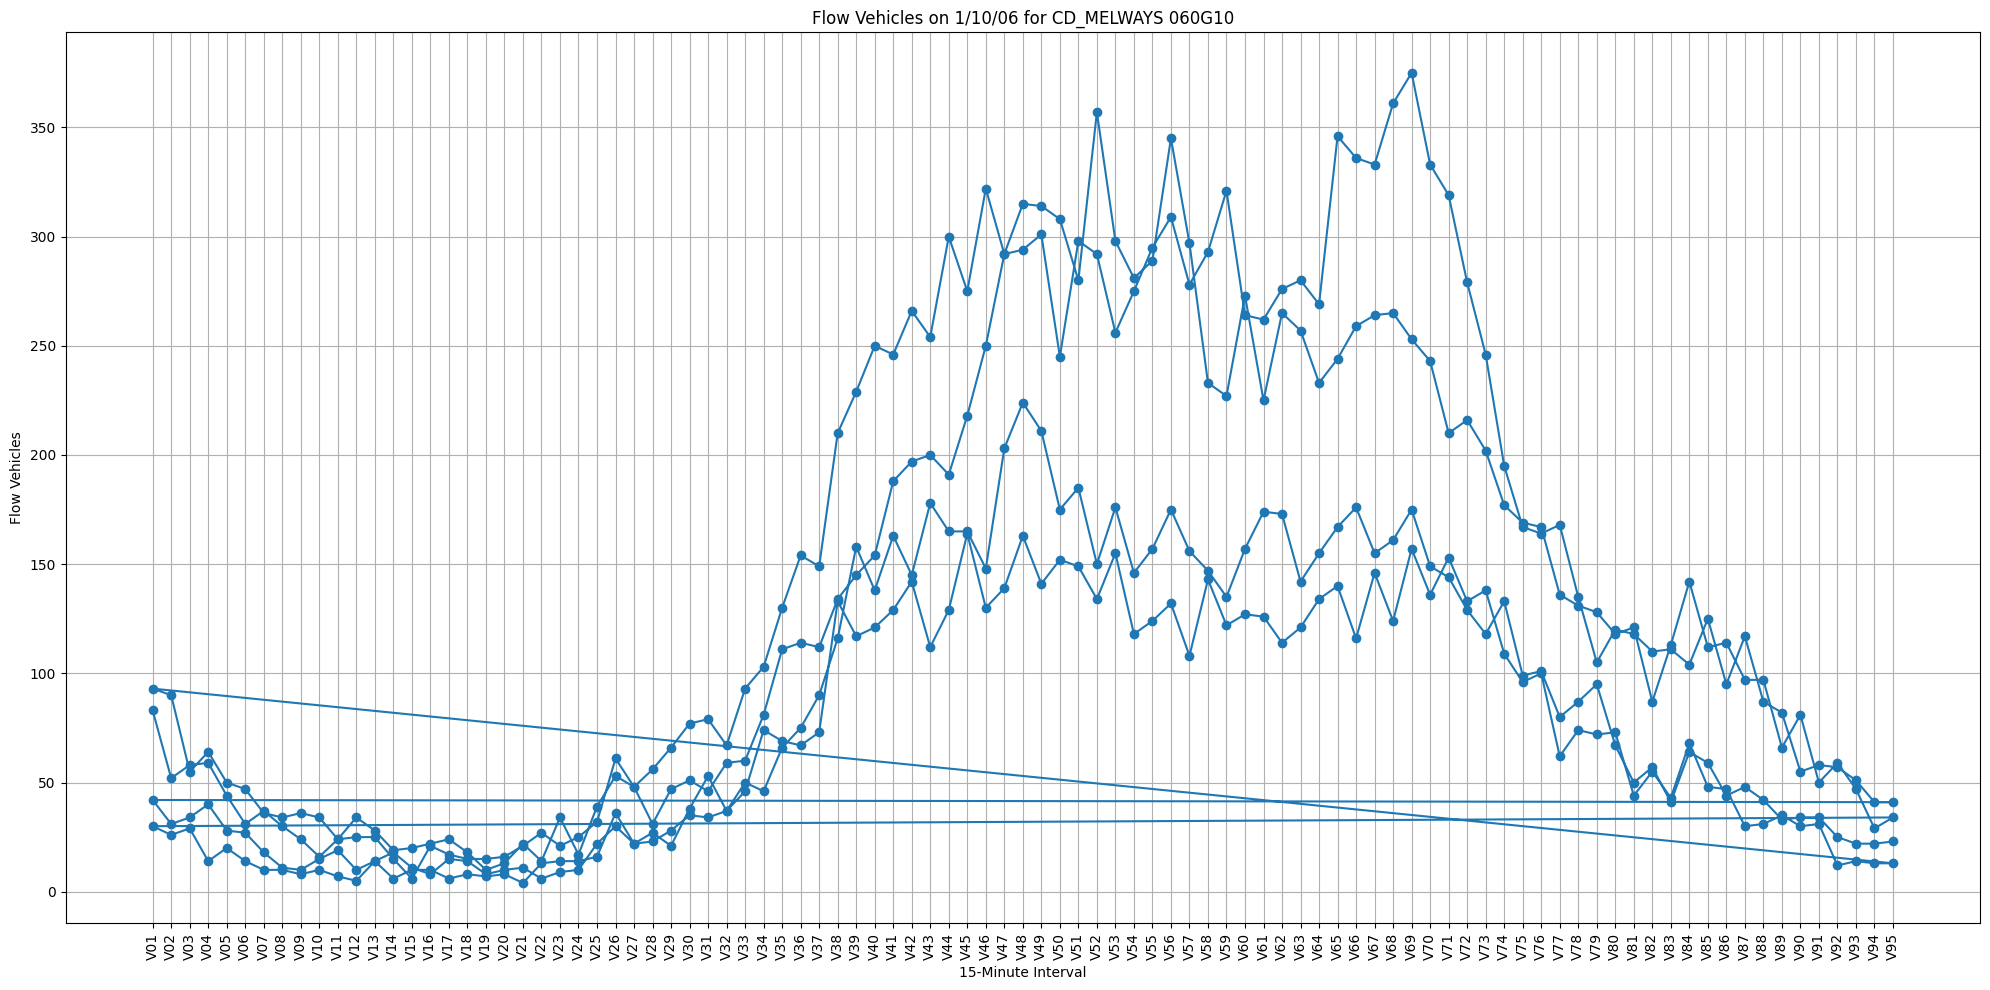

In [13]:
import matplotlib.pyplot as plt

# Now, let's plot the data, including filtering by Date and CD_MELWAYS
selected_date = '1/10/06'  # Example of filtering for a specific date
selected_cd_melways = '060G10'  # Example of filtering for a specific CD_MELWAYS

# Filter the data based on the selected date and CD_MELWAYS
filtered_data = final_df_scats_october[(final_df_scats_october['Date'] == selected_date) & 
                                  (final_df_scats_october['CD_MELWAYS'] == selected_cd_melways)]

# Plotting the filtered data
plt.figure(figsize=(20, 10))
plt.plot(filtered_data['15_Minute_Intervals'], filtered_data['Flow Vehicles'], marker='o')

plt.title(f'Flow Vehicles on {selected_date} for CD_MELWAYS {selected_cd_melways}')
plt.xlabel('15-Minute Interval')
plt.ylabel('Flow Vehicles')
plt.xticks(rotation=90)
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()